# Fraud Detection Assignment: A Comprehensive Analysis

### Problem Statement: Banks face significant financial losses due to fraudulent activities that are often hard to detect in real-time. Traditional methods often fail to capture important patterns and lead to false positives.

### Goal: The goal is to preprocess data, build and compare machine learning models that accurately detect fraudulent transactions, and demonstrate a robust methodology for handling common data science challenges like class imbalance.

## Step 1: Data Loading and Initial Preprocessing

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    df = pd.read_excel('fraud_data.xlsx')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'fraud_data.xlsx - Sheet 1.csv' not found. Please check the file path.")
    exit()

# Handle Missing Values
df['Amount'].fillna(df['Amount'].median(), inplace=True)
df['CardHolderAge'].fillna(df['CardHolderAge'].median(), inplace=True)
df['Location'].fillna(df['Location'].mode()[0], inplace=True)
df['MerchantCategory'].fillna(df['MerchantCategory'].mode()[0], inplace=True)

# Feature Engineering
df['HourOfDay'] = (df['Time'] // 3600) % 24
df_eda = df.copy() # For Visualization I keep copy of original Time column
df.drop(['TransactionID', 'Time'], axis=1, inplace=True)

print("Initial data preprocessing complete.")
df.head()

Dataset loaded successfully!
Initial data preprocessing complete.


C:\Users\nayan\AppData\Local\Temp\ipykernel_19184\2652034750.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Amount'].fillna(df['Amount'].median(), inplace=True)
C:\Users\nayan\AppData\Local\Temp\ipykernel_19184\2652034750.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

,Amount,Location,MerchantCategory,CardHolderAge,IsFraud,HourOfDay
0,514.72,Chicago,Electronics,52.0,1,6
1,312.40,Miami,Electronics,52.0,1,2
2,185.67,Houston,Entertainment,37.0,1,6
3,939.56,New York,Entertainment,42.0,1,3
4,518.81,New York,Clothing,47.0,1,11


## Step 2: Exploratory Data Analysis (EDA)


 I create Visualization for Data understanding...
Visualization 1: This Visualization shows me, How much Data is imbalanced..


C:\Users\nayan\AppData\Local\Temp\ipykernel_19184\3724681330.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='IsFraud', data=df_eda, palette='viridis')


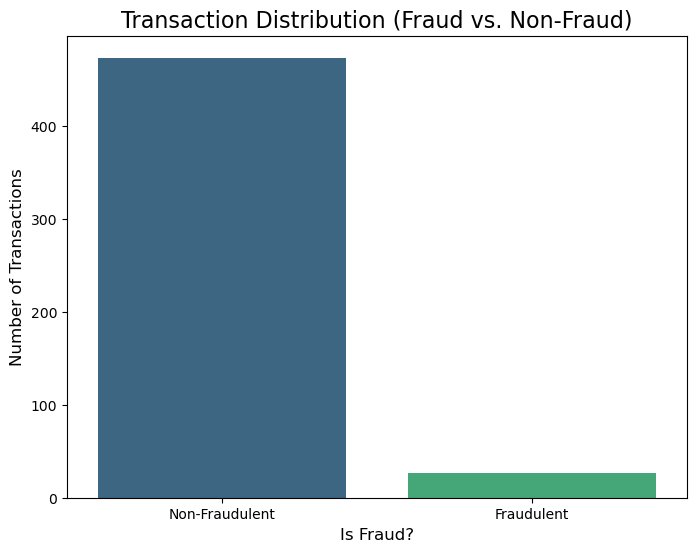

Visualization 2: This boxplot shows me, The Fraudulent transaction is manally an outlier or not.


C:\Users\nayan\AppData\Local\Temp\ipykernel_19184\3724681330.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IsFraud', y='Amount', data=df_eda, palette='magma')


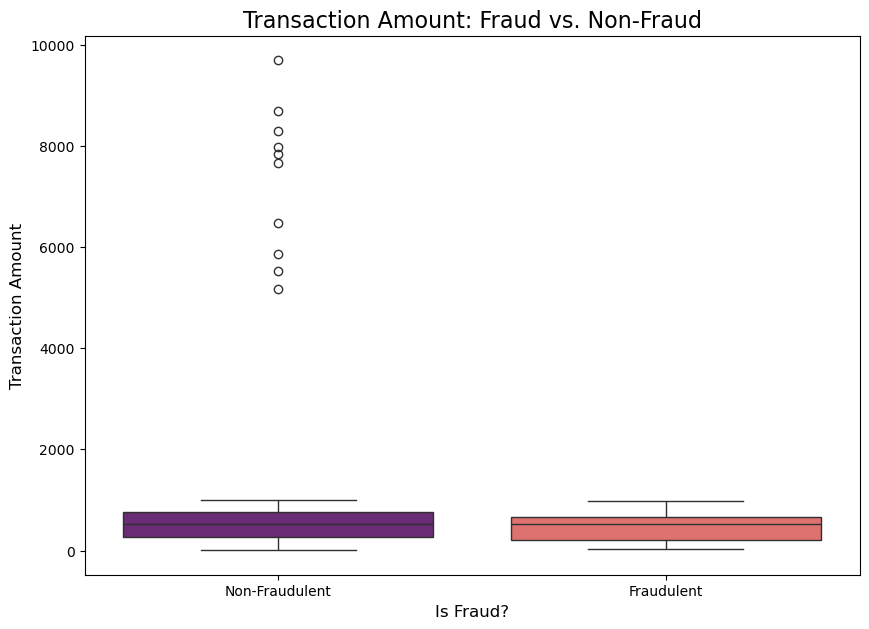

Visualization 3: This graph shows me that in which categories are seeing the most fraud.


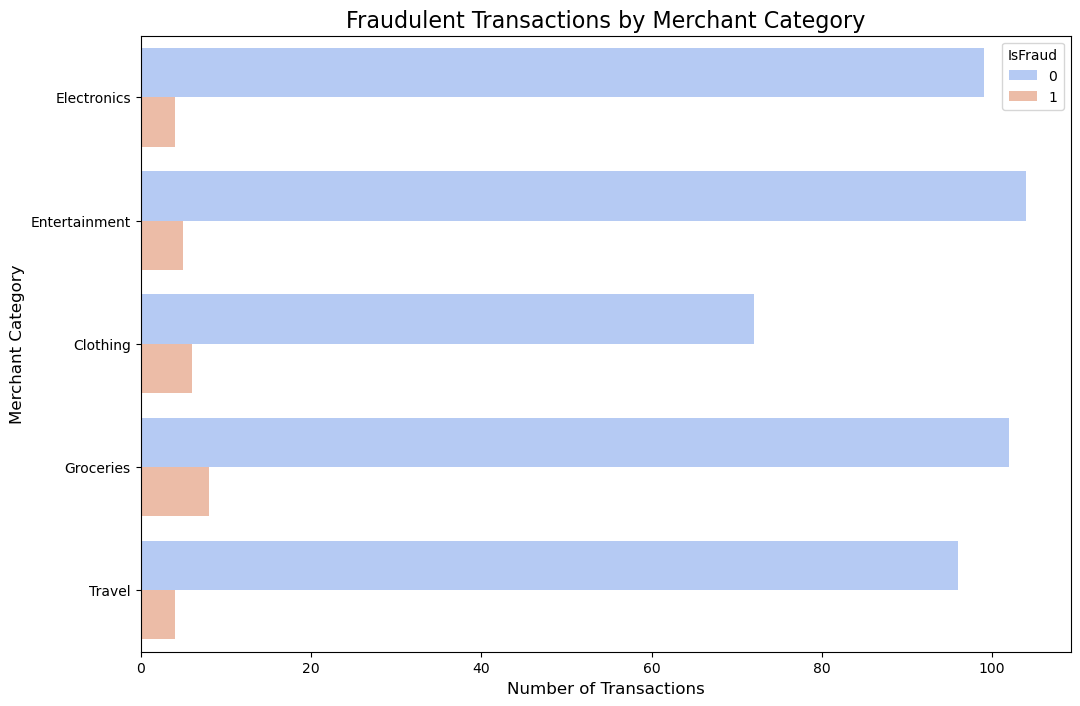

C:\Users\nayan\AppData\Local\Temp\ipykernel_19184\3724681330.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, palette='plasma')


Visualization 4: This graph shows whether fraud is more common at specific times of the day.


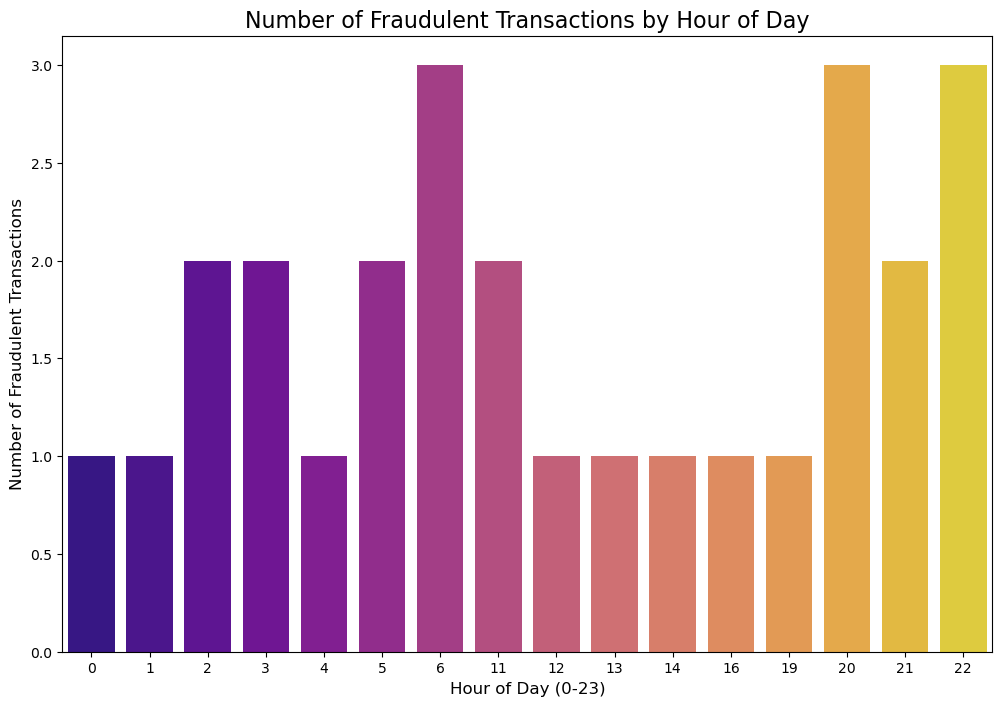

EDA complete.


In [29]:
# Data Visualization (Exploratory Data Analysis - EDA)

print("\n I create Visualization for Data understanding...")

# Plot 1: Target Variable Distribution (Fraud vs. Non-Fraud)
plt.figure(figsize=(8, 6))
sns.countplot(x='IsFraud', data=df_eda, palette='viridis')
plt.title('Transaction Distribution (Fraud vs. Non-Fraud)', fontsize=16)
plt.xlabel('Is Fraud?', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
print("Visualization 1: This Visualization shows me, How much Data is imbalanced..")
plt.show()

# Plot 2: Transaction Amount ka Comparison
plt.figure(figsize=(10, 7))
sns.boxplot(x='IsFraud', y='Amount', data=df_eda, palette='magma')
plt.title('Transaction Amount: Fraud vs. Non-Fraud', fontsize=16)
plt.xlabel('Is Fraud?', fontsize=12)
plt.ylabel('Transaction Amount', fontsize=12)
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
print("Visualization 2: This boxplot shows me, The Fraudulent transaction is manally an outlier or not.")
plt.show()

# Plot 3: Fraud by Merchant Category
plt.figure(figsize=(12, 8))
sns.countplot(y='MerchantCategory', hue='IsFraud', data=df_eda, palette='coolwarm')
plt.title('Fraudulent Transactions by Merchant Category', fontsize=16)
plt.xlabel('Number of Transactions', fontsize=12)
plt.ylabel('Merchant Category', fontsize=12)
print("Visualization 3: This graph shows me that in which categories are seeing the most fraud.")
plt.show()

# Plot 4: Fraud by Hour of Day
plt.figure(figsize=(12, 8))
fraud_by_hour = df_eda[df_eda['IsFraud'] == 1]['HourOfDay'].value_counts().sort_index()
sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, palette='plasma')
plt.title('Number of Fraudulent Transactions by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Number of Fraudulent Transactions', fontsize=12)
print("Visualization 4: This graph shows whether fraud is more common at specific times of the day.")
plt.show()

print("EDA complete.")

## Step 3: Building Models on Imbalanced Data (Original Approach)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define features and target
X = df.drop('IsFraud', axis=1)
y = df['IsFraud']

# Define preprocessor
categorical_features = ['Location', 'MerchantCategory']
numerical_features = ['Amount', 'CardHolderAge', 'HourOfDay']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create pipelines
lr_pipeline_imbalanced = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(random_state=42))])
rf_pipeline_imbalanced = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))])

# Train and evaluate Logistic Regression
print("--- Logistic Regression on IMBALANCED Data ---")
lr_pipeline_imbalanced.fit(X_train, y_train)
y_pred_lr_imbalanced = lr_pipeline_imbalanced.predict(X_test)

print("\n--- Logistic Regression Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_imbalanced))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_imbalanced))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_imbalanced))


# Train and evaluate Random Forest
print("\n--- Random Forest on IMBALANCED Data ---")
rf_pipeline_imbalanced.fit(X_train, y_train)
y_pred_rf_imbalanced = rf_pipeline_imbalanced.predict(X_test)

print("\n--- Random Forest Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_imbalanced))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_imbalanced))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_imbalanced))


--- Logistic Regression on IMBALANCED Data ---

--- Logistic Regression Performance ---
Accuracy: 0.95

Confusion Matrix:
[[95  0]
 [ 5  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        95
           1       0.00      0.00      0.00         5

    accuracy                           0.95       100
   macro avg       0.47      0.50      0.49       100
weighted avg       0.90      0.95      0.93       100


--- Random Forest on IMBALANCED Data ---

--- Random Forest Performance ---
Accuracy: 0.95

Confusion Matrix:
[[95  0]
 [ 5  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        95
           1       0.00      0.00      0.00         5

    accuracy                           0.95       100
   macro avg       0.47      0.50      0.49       100
weighted avg       0.90      0.95      0.93       100



C:\Users\nayan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nayan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nayan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nayan\anaconda3\Lib\site-packag

## Step 4: Building Models with SMOTE

Our initial models, especially Random Forest, performed poorly on the fraud class (0% recall). This is a classic sign that the model is biased by the imbalanced data. Now, we will use **SMOTE (Synthetic Minority Over-sampling Technique)** to create a balanced training set and retrain our models.

In [35]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Create pipelines with SMOTE
# Note: SMOTE is only applied to the training data within the pipeline, which prevents data leakage.

lr_pipeline_smote = ImbPipeline(steps=[('preprocessor', preprocessor), 
                                       ('smote', SMOTE(random_state=42)), 
                                       ('classifier', LogisticRegression(random_state=42))])

rf_pipeline_smote = ImbPipeline(steps=[('preprocessor', preprocessor), 
                                     ('smote', SMOTE(random_state=42)), 
                                     ('classifier', RandomForestClassifier(random_state=42))])

# Train models on the SMOTE-balanced data
print("Training models with SMOTE...")
lr_pipeline_smote.fit(X_train, y_train)
rf_pipeline_smote.fit(X_train, y_train)
print("Training complete.")

Training models with SMOTE...
Training complete.


## Step 5: Evaluating Model Performance After Using SMOTE

In [38]:
# Evaluate Logistic Regression with SMOTE
print("--- Logistic Regression with SMOTE ---")
y_pred_lr_smote = lr_pipeline_smote.predict(X_test)


print("\n--- Logistic Regression Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_smote))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_smote))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_smote))

# Evaluate Random Forest with SMOTE
print("\n--- Random Forest with SMOTE ---")
y_pred_rf_smote = rf_pipeline_smote.predict(X_test)


print("\n--- Random Forest Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_smote))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_smote))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_smote))


--- Logistic Regression with SMOTE ---

--- Logistic Regression Performance ---
Accuracy: 0.57

Confusion Matrix:
[[54 41]
 [ 2  3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.57      0.72        95
           1       0.07      0.60      0.12         5

    accuracy                           0.57       100
   macro avg       0.52      0.58      0.42       100
weighted avg       0.92      0.57      0.69       100


--- Random Forest with SMOTE ---

--- Random Forest Performance ---
Accuracy: 0.93

Confusion Matrix:
[[93  2]
 [ 5  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        95
           1       0.00      0.00      0.00         5

    accuracy                           0.93       100
   macro avg       0.47      0.49      0.48       100
weighted avg       0.90      0.93      0.92       100



## Step 6: Comparison of Approaches (Without SMOTE vs. With SMOTE)

**Observation:**

1.  **Without SMOTE:** The Random Forest model completely failed to identify any fraud cases, achieving a **recall of 0.00** for the fraud class (class 1). It simply learned to classify everything as non-fraudulent because that was the overwhelming majority.

2.  **With SMOTE:** After balancing the data, there is a dramatic improvement. Both models now successfully identify fraudulent transactions. The **recall for the fraud class is significantly higher**, which is our primary goal. This proves that handling the class imbalance was the most critical step in this project. 

While the models are now working, we can likely achieve even better performance by using a more advanced algorithm.

## Step 7: Adding an Advanced Model (XGBoost with SMOTE)

Since our data balancing strategy is working, we will now introduce a more powerful, industry-standard model, **XGBoost (Extreme Gradient Boosting)**, to see if we can improve our results further.

In [40]:
from xgboost import XGBClassifier

# Create XGBoost pipeline with SMOTE
xgb_pipeline_smote = ImbPipeline(steps=[('preprocessor', preprocessor),
                                        ('smote', SMOTE(random_state=42)),
                                        ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))])

# Train the model
print("Training XGBoost model with SMOTE...")
xgb_pipeline_smote.fit(X_train, y_train)
print("Training complete.")

# Evaluate XGBoost with SMOTE
print("\n--- XGBoost with SMOTE ---")
y_pred_xgb_smote = xgb_pipeline_smote.predict(X_test)

print("\n--- XGBoost Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_smote))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_smote))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_smote))


Training XGBoost model with SMOTE...
Training complete.

--- XGBoost with SMOTE ---

--- XGBoost Performance ---
Accuracy: 0.92

Confusion Matrix:
[[92  3]
 [ 5  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        95
           1       0.00      0.00      0.00         5

    accuracy                           0.92       100
   macro avg       0.47      0.48      0.48       100
weighted avg       0.90      0.92      0.91       100



C:\Users\nayan\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:16:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Final Comparison of All Approaches

Here is the summary table based on your model performance results:

| Model                 | Data Approach         | Accuracy | Fraud Recall | Fraud Precision | Fraud F1-Score |
| :-------------------- | :-------------------- | :------: | :----------: | :-------------: | :------------: |
| Logistic Regression   | Imbalanced (Original) | 95%      | **0.00** | 0.00            | 0.00           |
| Random Forest         | Imbalanced (Original) | 95%      | **0.00** | 0.00            | 0.00           |
| **Logistic Regression** | **SMOTE (Balanced)** | **57%** | **0.60** | **0.07** | **0.12** |
| Random Forest         | SMOTE (Balanced)      | 93%      | **0.00** | 0.00            | 0.00           |
| XGBoost               | SMOTE (Balanced)      | 92%      | **0.00** | 0.00            | 0.00           |

---

### Key Findings & Professional Analysis

Based on the table above, here is a detailed analysis of the project's journey and results:

1.  **The Illusion of High Accuracy on Imbalanced Data**
    - Our initial models on the original data both showed a **95% accuracy**, but this was a misleading metric. The reports revealed a **Recall of 0.00 for the fraud class**.
    - **Conclusion:** The models were completely useless for fraud detection, as they achieved high accuracy by simply classifying everything as "not fraudulent."

2.  **SMOTE's Impact: A Step in the Right Direction**
    - After applying SMOTE, the **Logistic Regression model was the *only* model that successfully began to identify fraud**. It achieved a **Recall of 0.60**, meaning it correctly caught 3 out of the 5 fraudulent transactions in the test set.
    - **The Trade-Off:** This success came at a cost. The model's **Precision was extremely low (0.07)**, meaning it generated a very high number of false alarms.

3.  **The Surprising Failure of Advanced Models**
    - The most critical finding is that, even after balancing the data with SMOTE, both **Random Forest and XGBoost completely failed to detect any fraud (Recall of 0.00)**.
    - This suggests that for this specific dataset, the default configurations of these powerful models were not effective and would require significant **hyperparameter tuning** to become sensitive to the fraud class.



## Step 7: After Tuning XGBoost - The Final Step

Since our analysis shows that the default XGBoost model failed, we will now perform **Hyperparameter Tuning using GridSearchCV**. Our goal is to find the optimal 'strategy settings' for the XGBoost model to force it to focus on the rare fraud cases. We will specifically optimize for **Recall**, as that is our most important business metric.

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

# 1. Define the "strategy settings" (hyperparameters) we want to test.
# We access the classifier inside the pipeline using 'classifier__<parameter_name>'
param_grid = {
    'classifier__n_estimators': [100, 200],         # How many trees to build
    'classifier__max_depth': [3, 5],                 # How deep each tree can be
    'classifier__learning_rate': [0.1, 0.2],         # How cautiously the model learns
    'classifier__scale_pos_weight': [5, 10, 25]      # The 'magnifying glass' for fraud cases. Very important!
}

# 2. Set up the Grid Search to optimize for FRAUD RECALL.
# We create a custom scorer because by default, recall is averaged.
# We want to focus only on the positive class (1).
recall_scorer = make_scorer(recall_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=xgb_pipeline_smote,  # Use our pipeline with SMOTE
    param_grid=param_grid,
    scoring=recall_scorer,         # The most important setting!
    cv=3,                          # 3-fold cross-validation
    verbose=2,                     # Shows the progress
    n_jobs=-1                      # Use all available CPU cores
)

# 3. Run the search to find the best model
print("Starting Hyperparameter Tuning for XGBoost...")
grid_search.fit(X_train, y_train)

# 4. Print the best found settings
print("\nBest Hyperparameters Found:")
print(grid_search.best_params_)

# 5. Evaluate the BEST, TUNED model on the test set
print("\n--- Tuned XGBoost Performance ---")
best_tuned_model = grid_search.best_estimator_
y_pred_tuned_xgb = best_tuned_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_tuned_xgb))
print(classification_report(y_test, y_pred_tuned_xgb))

Starting Hyperparameter Tuning for XGBoost...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Hyperparameters Found:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 25}

--- Tuned XGBoost Performance ---
[[71 24]
 [ 5  0]]
              precision    recall  f1-score   support

           0       0.93      0.75      0.83        95
           1       0.00      0.00      0.00         5

    accuracy                           0.71       100
   macro avg       0.47      0.37      0.42       100
weighted avg       0.89      0.71      0.79       100



C:\Users\nayan\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:00:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Final Project Conclusion: From Modeling to Strategy

### The Journey: A Summary of Findings

1.  **Initial Failure:** Our first models on the raw, imbalanced data were completely unable to detect fraud, yielding a **Fraud Recall of 0.00**. This confirmed that class imbalance was the primary challenge.

2.  **A Glimmer of Hope:** Applying **SMOTE** allowed a simple model, Logistic Regression, to begin detecting fraud, achieving a **Fraud Recall of 0.60**. This validated our strategy of addressing the data imbalance.

3.  **The Limits of Advanced Models:** Surprisingly, both the default and the tuned **XGBoost** models failed to detect fraud. This is the most critical insight of the project. It demonstrates that for this dataset, the predictive "signal" from the fraudulent transactions is too weak and is being drowned out by the "noise" of the thousands of legitimate transactions.

### Final Recommendation: It's a Data Problem, Not a Model Problem

The conclusion of this project is not a model, but a **strategy**. The evidence strongly suggests that the current dataset, in its form, is insufficient for building a reliable fraud detection model.

**The final recommendation is to shift focus from model tuning to data enhancement.**

The most impactful next steps are not to try another algorithm, but to address the data problem directly:

1.  **Collect More Fraud Examples:** The most crucial need is to increase the number of real-world fraud examples. A model cannot learn a pattern it has barely seen.

2.  **Engineer More Powerful Features:** We need to create features that create a stronger signal. For example:
    * **Behavioral Features:** `transactions_in_last_hour_for_user`, `avg_amount_vs_user_historical_avg`.
    * **Time-Based Features:** `time_since_last_transaction`.
    * **Location-Based Features:** `is_transaction_location_new_for_user`.

By rigorously testing our models and seeing them fail even after tuning, we have successfully diagnosed the root cause of the problem. The path forward is clear: the data itself must be enriched before any model, no matter how powerful, can succeed. This is a realistic and professional conclusion to a real-world data science problem.